In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD

In [3]:
from keras.metrics import MeanSquaredError 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad
from keras.optimizers import Adam
from keras.optimizers import Nadam

In [4]:
all_data1=pd.read_csv('삼성전자주가(20220406-20240405).csv')
print('Number of rows and columns:', all_data1.shape)
all_data1["Datetime"] = pd.to_datetime(all_data1["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
all_data1['Datetime'] = pd.to_datetime(all_data1['Datetime'])
all_data1.set_index('Datetime', inplace=True)
all_data1.head(5) # volume = 거래량

Number of rows and columns: (2960, 7)


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688


In [5]:
all_data1[all_data1['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,0
2022-04-07 09:00:00,68500.0,68500.0,68100.0,68400.0,68400.0,0
2022-04-08 09:00:00,68100.0,68300.0,68000.0,68100.0,68100.0,0
2022-04-11 09:00:00,67800.0,67900.0,67400.0,67700.0,67700.0,0
2022-04-12 09:00:00,67600.0,67700.0,67400.0,67600.0,67600.0,0
...,...,...,...,...,...,...
2024-03-04 09:00:00,74300.0,75000.0,74000.0,74600.0,74600.0,0
2024-03-11 09:00:00,72900.0,73100.0,72500.0,72700.0,72700.0,0
2024-03-18 09:00:00,72600.0,72900.0,72500.0,72800.0,72800.0,0


In [6]:
all_data1['change']=0
all_data1['target']=0
for i in range(len(all_data1)-1):
    all_data1.iloc[i+1,6]=all_data1.iloc[i+1,3]-all_data1.iloc[i,3]
all_data1.loc[all_data1['change']==0, 'target']=0
all_data1.loc[all_data1['change']<0, 'target']=-1
all_data1.loc[all_data1['change']>0, 'target']=1

In [7]:
all_data1

,Open,High,Low,Close,Adj Close,Volume,change,target
Datetime,,,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,0,0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582,0,0
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392,-100,-1
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045,0,0
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688,0,0
...,...,...,...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,84000.0,3548675,-700,-1
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,84200.0,1732644,200,1
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,84400.0,1052082,200,1


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

features = all_data1[['Open', 'High', 'Low', 'change', 'Volume', 'Close']].values
sc = MinMaxScaler(feature_range=(0,1)) #Normalizer() #StandardScaler() RobustScaler()
data= sc.fit_transform(features)

# 데이터셋 생성
def create_dataset(data, seq_len):
    x_data, y_data = [], []
    for i in range(len(data) - seq_len):
        x_data.append(data[i:i + seq_len])
        y_data.append(data[i + seq_len,3])
    return np.array(x_data), np.array(y_data)

# 시퀀스 길이 (7일)
SEQ_LEN = 7

train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

# 시퀀스 생성을 고려한 인덱스
end_train = train_size - SEQ_LEN
end_val = train_size + val_size - SEQ_LEN

X_train, y_train = create_dataset(data[:train_size], SEQ_LEN)
X_val, y_val = create_dataset(data[train_size:train_size+val_size], SEQ_LEN)
X_test, y_test = create_dataset(data[train_size+val_size:], SEQ_LEN)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader 설정
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=False)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=False)

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, 3, :])
        return out

# 입력 차원
input_size = X_train_tensor.shape[2]
# 은닉 상태 크기
hidden_size = 100
# 출력 차원
output_size = 1

# 모델 생성
model = LSTMModel(input_size, hidden_size, output_size)
print(model)
def RMSELoss(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

# 옵티마이저 정의 (Adam)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실 함수 설정
criterion = RMSELoss

# 학습 파라미터 설정
num_epochs = 100
train_losses = []
val_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patience = 25  # 검증 손실이 개선되지 않는 에포크 허용 횟수
min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
last_val_loss = np.inf
patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터
# 모델 학습
for epoch in range(num_epochs):
    model.train()  # 학습 모드로 설정
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        # 입력 데이터와 레이블을 GPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 기울기 초기화
        optimizer.zero_grad()
        
        # 순방향 전파
        outputs = model(inputs)
        
        # 손실 계산
        loss = criterion(outputs.squeeze(), labels)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        # 손실 누적
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0

    with torch.no_grad():
        model.eval()
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * inputs.size(0)  # 누적 손실 계산

    # 에포크별 평균 검증 손실 계산
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early Stopping Counter {patience_counter} of {patience}')

    last_val_loss = val_loss  # 마지막 검증 손실 업데이트

    if patience_counter >= patience:
        print("Early stopping initiated.")
        print(f"Best Validation Loss: {best_loss:.5f}")
        break

LSTMModel(
  (lstm): LSTM(6, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Epoch 1/100, Train Loss: 0.09179, Val Loss: 0.07112
Epoch 2/100, Train Loss: 0.07391, Val Loss: 0.07151
Early Stopping Counter 1 of 25
Epoch 3/100, Train Loss: 0.07389, Val Loss: 0.08300
Early Stopping Counter 2 of 25
Epoch 4/100, Train Loss: 0.07700, Val Loss: 0.08226
Early Stopping Counter 3 of 25
Epoch 5/100, Train Loss: 0.07634, Val Loss: 0.07964
Early Stopping Counter 4 of 25
Epoch 6/100, Train Loss: 0.07515, Val Loss: 0.07868
Early Stopping Counter 5 of 25
Epoch 7/100, Train Loss: 0.07459, Val Loss: 0.07830
Early Stopping Counter 6 of 25
Epoch 8/100, Train Loss: 0.07425, Val Loss: 0.07813
Early Stopping Counter 7 of 25
Epoch 9/100, Train Loss: 0.07400, Val Loss: 0.07804
Early Stopping Counter 8 of 25
Epoch 10/100, Train Loss: 0.07381, Val Loss: 0.07798
Early Stopping Counter 9 of 25
Epoch 11/100, Train Loss: 0.07365, Val Loss: 0.07794
Early Stopping Counter 10 of 25
Ep

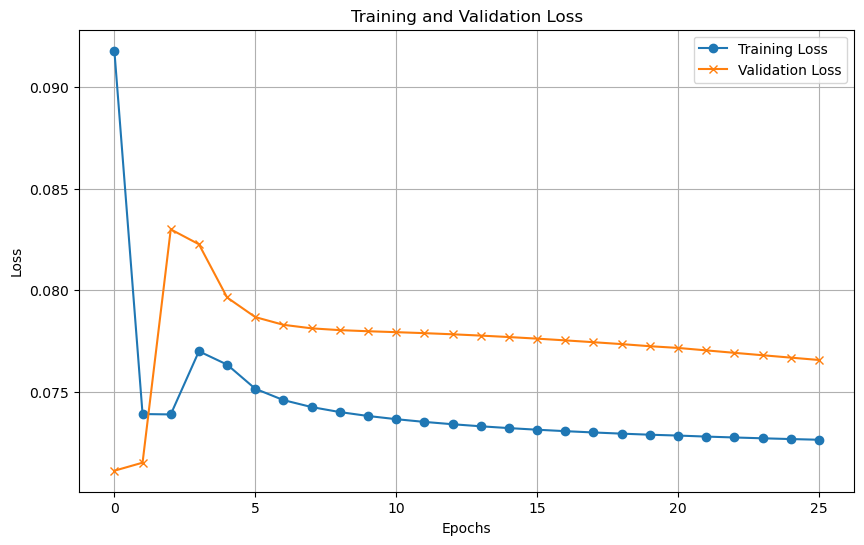

In [10]:
import matplotlib.pyplot as plt

# 위에 제시된 훈련 및 검증 과정 코드 실행 후 실행

# 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
plt.plot(val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
plt.title('Training and Validation Loss')  # 그래프 제목
plt.xlabel('Epochs')  # x축 라벨
plt.ylabel('Loss')  # y축 라벨
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 보여주기

In [16]:
# 테스트 데이터셋에 대한 평가 및 결과 출력

model.eval()  # 모델을 평가 모드로 설정
test_losses = []  # 테스트 손실을 저장할 리스트
predictions = []  # 예측값을 저장할 리스트
actuals = []  # 실제값을 저장할 리스트

with torch.no_grad():  # 기울기 계산을 비활성화
    for seqs, labels in test_loader:

        outputs = model(seqs)

        # 손실 계산
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        # 예측값과 실제값 저장
        predictions.extend(outputs.view(-1).detach().numpy())
        actuals.extend(labels.view(-1).detach().numpy())

# 평균 테스트 손실 계산 및 출력
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss}')
predictions_temp = np.zeros((len(predictions), 6))  # 6는 특성의 총 개수입니다.
predictions_temp[:, 3] = predictions  # 종가 위치에 예측값 할당

actuals_temp = np.zeros((len(actuals), 6))  # 실제 데이터를 위한 동일한 접근 방식
actuals_temp[:, 3] = actuals  # 종가 위치에 실제값 할당

# 예측값과 실제값 출력 (처음 10개 샘플)
yest=np.delete(np.insert(sc.inverse_transform(X_test[:,-1,:])[:,-1], 0, 0), -1)
predictions_inverse = np.round(sc.inverse_transform(predictions_temp)[:,3], -2)+yest
actuals_inverse = np.round(sc.inverse_transform(actuals_temp)[:,3], -2)+yest

# 역정규화된 예측값과 실제값 출력 (처음 10개 샘플)
print("Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):")
for i in range(10):
    print(f'Prediction: {predictions_inverse[i]:.4f}, Actual: {actuals_inverse[i]:.4f}')

Average Test Loss: 0.098678712586039
Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):
Prediction: -200.0000, Actual: -200.0000
Prediction: 73900.0000, Actual: 74000.0000
Prediction: 73700.0000, Actual: 74200.0000
Prediction: 73600.0000, Actual: 73700.0000
Prediction: 73900.0000, Actual: 74300.0000
Prediction: 73800.0000, Actual: 73500.0000
Prediction: 74000.0000, Actual: 74200.0000
Prediction: 73500.0000, Actual: 74100.0000
Prediction: 73500.0000, Actual: 74100.0000
Prediction: 73900.0000, Actual: 74100.0000


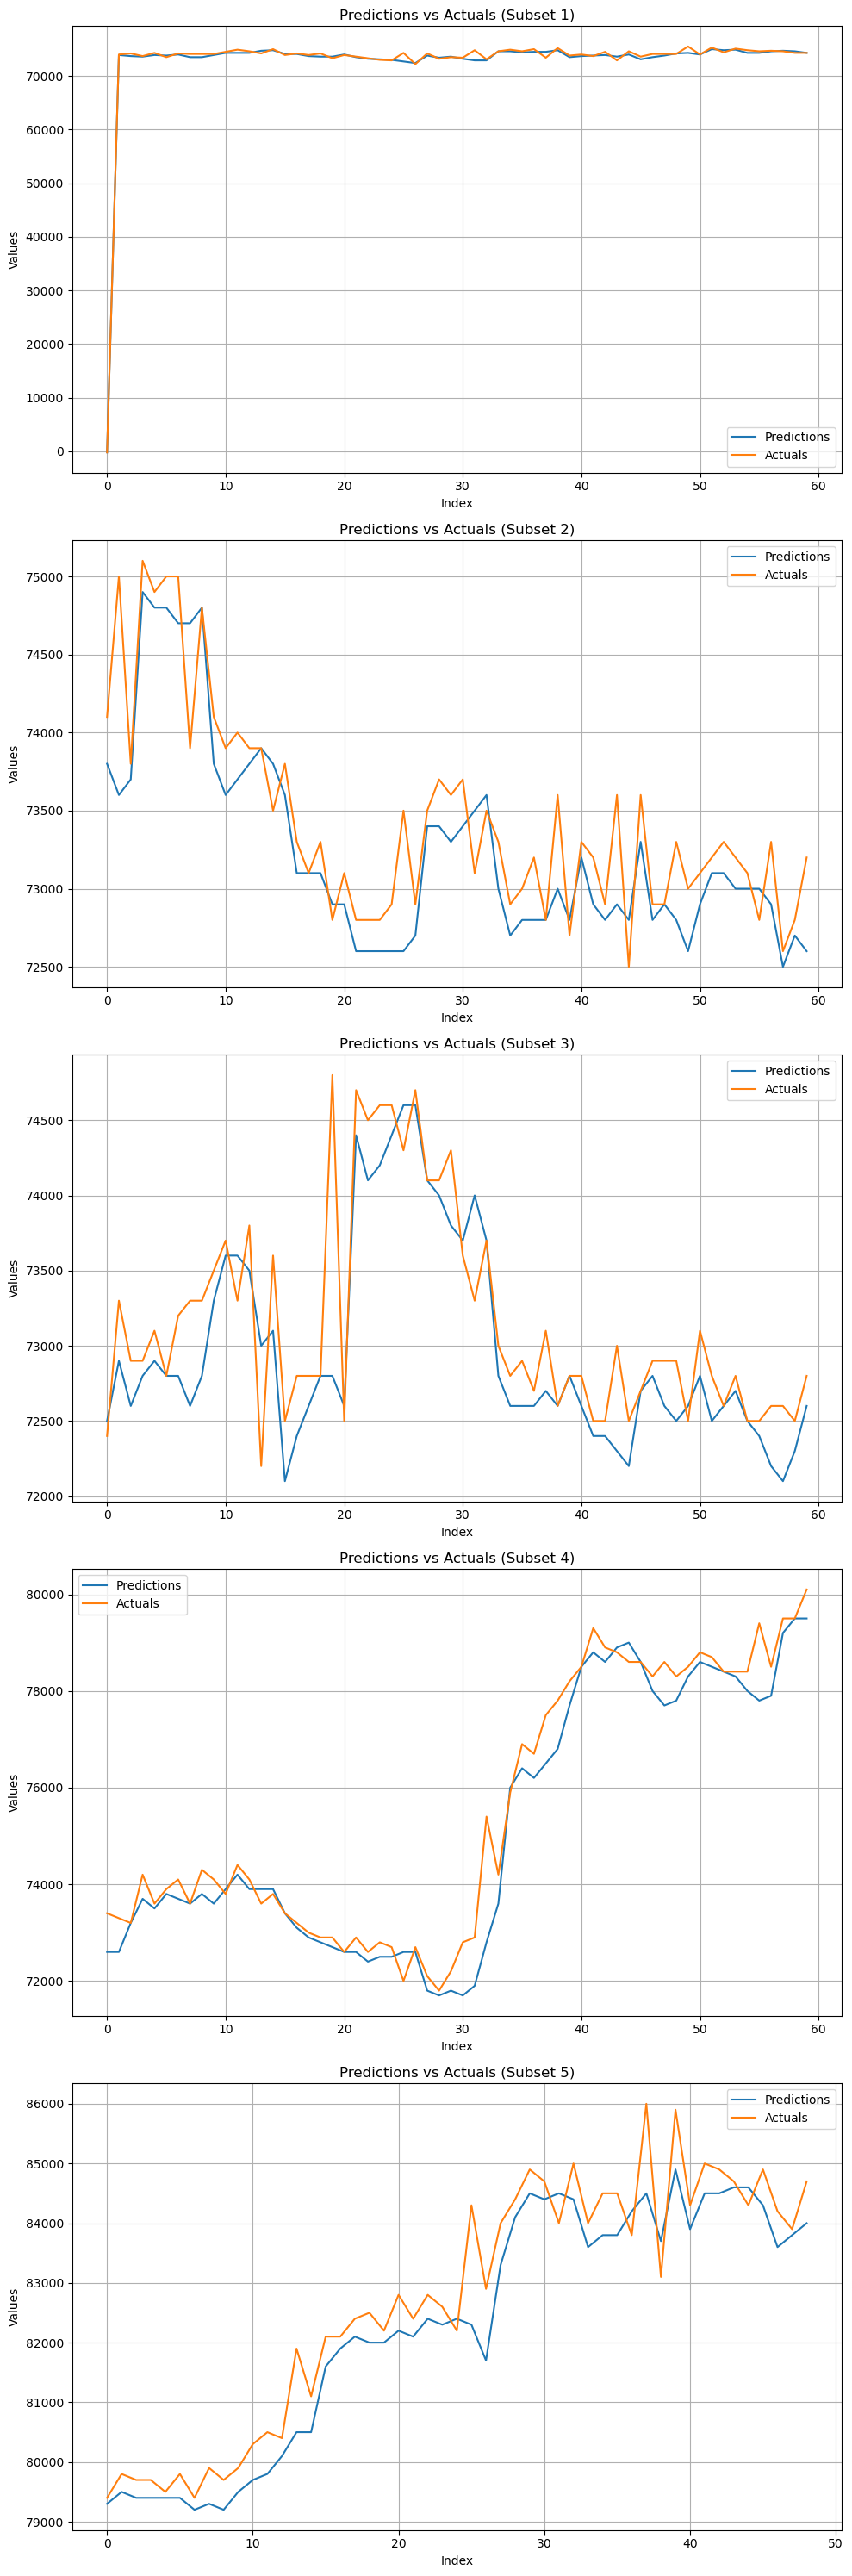

In [17]:
import matplotlib.pyplot as plt

# 전체 데이터를 4개로 나누기
n = 60
num_plots = len(predictions_inverse) // n
if len(predictions_inverse) % n != 0:
    num_plots += 1

# Plot 생성
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

for i in range(num_plots):
    start_index = i * n
    end_index = min((i + 1) * n, len(predictions_inverse))
    
    # Subplot 생성
    ax = axes[i] if num_plots > 1 else axes
    
    # 예측값과 실제값 그리기
    ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
    ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
    ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()